# Activity 5.1 Neural Network
In this activity we build a simple three layer Neural Network for the classification problem. We study the effect of initialization on model selection. 

# Linearly Separable Classes
## Synthetic Data Generation 
Here we follow an approach similar to what we took to produce the datasets for classification problems in Module 3.

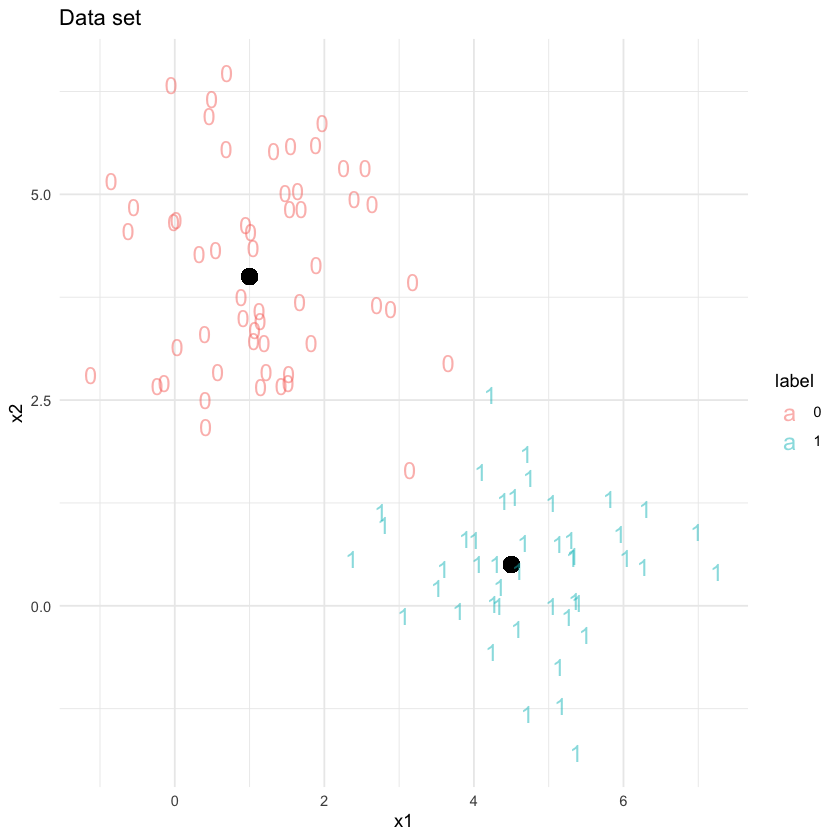

In [1]:
# Data Generation
## Libraries:
library(mvtnorm) # generates multivariate Gaussian sampels and calculate the densities
library(ggplot2)
library(reshape2)

## Setting parameters
set.seed(12345) # set random seed
N <- 100 # total number of samples
D <- 2 # number of dimensions

## Initialization
c0 <- '0'; c1 <- '1' # class labels
mu0 <- c(1.0, 4.0); p0 <- 0.60
mu1 <- c(4.5, 0.5); p1 <- 1 - p0

sigma <- matrix(c(1, 0, 0, 1), nrow=2, ncol=2, byrow = TRUE) # shared covariance matrix
sigma0 <- sigma;   sigma1 <- sigma

data <- data.frame(x1=double(), x2=double(), label=double()) # empty data.frame

## Generate class labels
data[1:N,'label'] <- sample(c(c0,c1), N, replace = TRUE, prob = c(p0, p1))

## calculate the size of each class
N0 <- sum(data[1:N,'label']==c0); N1 <- N - N0

## Sample from the Gaussian distribution accroding to the class labels and statitics.
data[data$label==c0, c('x1', 'x2')] <- rmvnorm(n = N0, mu0, sigma0)
data[data$label==c1, c('x1', 'x2')] <- rmvnorm(n = N1, mu1, sigma1)

## Split data to train and test datasets
train.len <- round(N/2)
train.index <- sample(N, train.len, replace = FALSE)
train.data <- data[train.index, c('x1', 'x2')]; test.data <- data[-train.index, c('x1', 'x2')]
train.label <- data[train.index, 'label']; test.label <- data[-train.index, 'label']

## Take a look at the data set
ggplot(data=data[1:N,], aes(x=x1, y=x2, color=label, label=ifelse(label==c0, '0', '1'))) +
    geom_point(x=mu0[1], y=mu0[2], size=4, color = 'black') +
    geom_point(x=mu1[1], y=mu1[2], size=4, color = 'black') +
    geom_text(size = 5, alpha=0.5) + ggtitle ('Data set') + theme_minimal()

## Neural Network
In this example we implement a simple 3-layer (i.e., the input layer, one hidden layer and the output layer) network with sigmoid as the activation function.

### Auxiliary Functions
We need to define some auxiliary functions. In particular, we implement activation function `h` and its derivitive `h.d`. Then, we will have output `probability` function that for each point it calculates the probability of being a memeber of class `c1` (in the output layer). Finally, we implement `prediction` and `accuracy` funcitons that calculate the class labels and the accuracy percentage, respectively.

**Note 1:** Since the output of our neural network is the probability of class `c1`, we classify the points with any probability larger thatn `0.5` as a member of `c1`. All the other points will be labeled as `c0`.

**Note 2:** The structure `list` that is defined at the end of the following piece of code helps us to define functions that can return multiple variables at the same time. We will use this structure in the `feedforward` and `backpropagation` functions.

In [2]:
# auxiliary functions 
## the activation function (sigmoid here)
h <- function(z) { 
    return (1/(1+exp(-3*z)))
}
## the derivitive of the activation function (sigmoid here)
h.d <- function(z) {
    return (h(z)*(1-h(z)))
}
## Class Probabilities
probability <- function(X, W1, W2, b1, b2){
    a2 <- h(sweep(W1 %*% X, 1, b1,'+' ))
    a3 <- h(sweep(W2 %*% a2, 1, b2,'+' ))
    return (a3)
}
## prediction
prediction <- function(X, W1, W2, b1, b2, threshold=0.5){
    return (ifelse(probability(X, W1, W2, b1, b2)>=threshold, 1, 0))
}
## Accuracy
accuracy <- function(Y, T){
    return (sum(Y==T)/length(T)*100)
}
## The following structure helps us to have functions with multiple outputs
### credit: https://stat.ethz.ch/pipermail/r-help/2004-June/053343.html
list <- structure(NA,class="result")
"[<-.result" <- function(x,...,value) {
   args <- as.list(match.call())
   args <- args[-c(1:2,length(args))]
   length(value) <- length(args)
   for(i in seq(along=args)) {
     a <- args[[i]]
     if(!missing(a)) eval.parent(substitute(a <- v,list(a=a,v=value[[i]])))
   }
   x
}

### Name Conventions
To make a more readable code, let's do some name convention. In particular, we choose variable names to be close to the math terms in Chapter 2. Form now on, `N` referes to the number of training data. `X1` and `T1` indicate to train data and labels, while `X2` and `T2` refer to test data and labels, respectively.

`Wn` and `bn` are refereing to weight matrix and bias term for layer `n` (here `n` is either `1` or `2`), and `.d` stands for delta. Finally, `an` and `zn` are denoting the total weighted sum activation and its activation value (here `n` is in `[1:3]`).

The following code does nothing but some data convertions.

In [3]:
# Some conversions:
## rename just for convenience
N <- train.len 
## convert data and labels to matrices
X1 <- t(unname(data.matrix(train.data))) 
T1 <- t(data.matrix(as.numeric(train.label))) 
X2 <- t(unname(data.matrix(test.data))) 
T2 <- t(data.matrix(as.numeric(test.label))) 

### Feedforward Function
The following function perform one feedforward pass for a 3-layer feedforward network. We will call this function in a loop to train our network.

In [4]:
feedforward <- function(Xi, Ti, W1, b1, W2, b2){
    ### 1st (input) layer 
    a1 <- Xi
    y <- Ti
    ### 2nd (hidden) layer
    z2 <- W1 %*% a1 + b1
    a2 <- h(z2)        
    ### 3rd (output) layer
    z3 <- W2 %*% a2 + b2
    a3 <- h(z3)  
    return(list(a1, a2, a3, y, z2, z3))
}

### Backpropagation Function
The following function perform one backpropagation pass for a 3-layer feedforward network. We will call this function after each feedforward step..

In [5]:
backpropagation <- function(Ti, W2, z2, z3, a3){
    ### 3rd (output) layer
    d3 <- -(Ti-a3) * h.d(z3)
    ### 2nd (hidden) layer
    d2 <-  t(W2)%*%d3  * h.d (z2)
    return(list(d2,d3))
}

### Initialization
Like any other algorithm, NN starts with some parameter settings and initializations. Here, `K` indicates the number of units in the hidden layer.

In [6]:
# Setting parameters
K <- 3 # number of units in the hidden layer
epoch.max <- 1000 # maximum number of iterations
eta <- 0.1 # learning rate
lambda <- 0.0001 # regularization term

# initialization
epoch <- 1 # epoch (iteration) counter
terminate <- FALSE   # termination criteria

## weight vectors/matrices initialization
### w stands for weight and b for bias
### the numbers after the letters indicates the layer number
W1 <- matrix(0.01*rnorm(D*K, sd=0.5), nrow=K, ncol=D)
b1 <- matrix(0*rnorm(1*K), nrow=K, ncol=1)
W2 <- matrix(0.01*rnorm(K*1, sd=0.5), nrow=1, ncol=K)
b2 <- matrix(0*rnorm(1*1), nrow=1, ncol=1)

## tracing accuracy of the model 
train.accuracy <- matrix(0,nrow=epoch.max, ncol=1)

### Main Loop
Now it's time to iteratively run the feed-forward and back-propagation passes.

In [7]:
# main loop
while (!terminate){
    
    ## delta vectors/matrices initialization (for batch backpropagation)
    ### .d stands for delta
    W1.d <- W1 *0
    b1.d <- b1 *0
    W2.d <- W2 *0
    b2.d <- b2 *0
    
    ## inner loop for each train sample
    for (i in 1:N){
       
        ## Feedforward:
        list[a1, a2, a3, y, z2, z3] <- feedforward(X1[,i], T1[i], W1, b1, W2, b2)

        ## Backpropagation:
        list[d2, d3] <- backpropagation(T1[i], W2, z2, z3, a3)

        ## calculate the delta values
        ### 1st layer
        W1.d <- W1.d + d2 %*% t(a1)
        b1.d <- b1.d + d2
        ### 2nd layer
        W2.d <- W2.d + d3 %*% t(a2)
        b2.d <- b2.d + d3

    }
    
    ## update weight vectors and matrices
    ### 1st (input) layer
    W1 <- W1 - eta * (W1.d/N + lambda*W1)
    b1 <- b1 - eta * (b1.d/N)
    ### 2nd (hidden) layer
    W2 <- W2 - eta * (W2.d/N + lambda*W2)
    b2 <- b2 - eta * (b2.d/N)

    ## trace train accuracy
    train.accuracy[epoch]<- accuracy(prediction(X1, W1, W2, b1, b2), T1)
    
    ## increase the iteration counter
    epoch <- epoch + 1
    
    ## check the termination criteria
    if (epoch > epoch.max) {terminate <- TRUE}
}
print('Done!')

[1] "Done!"


### Evaluation
Let's visualize the classification accuracy trend as the training goes on:

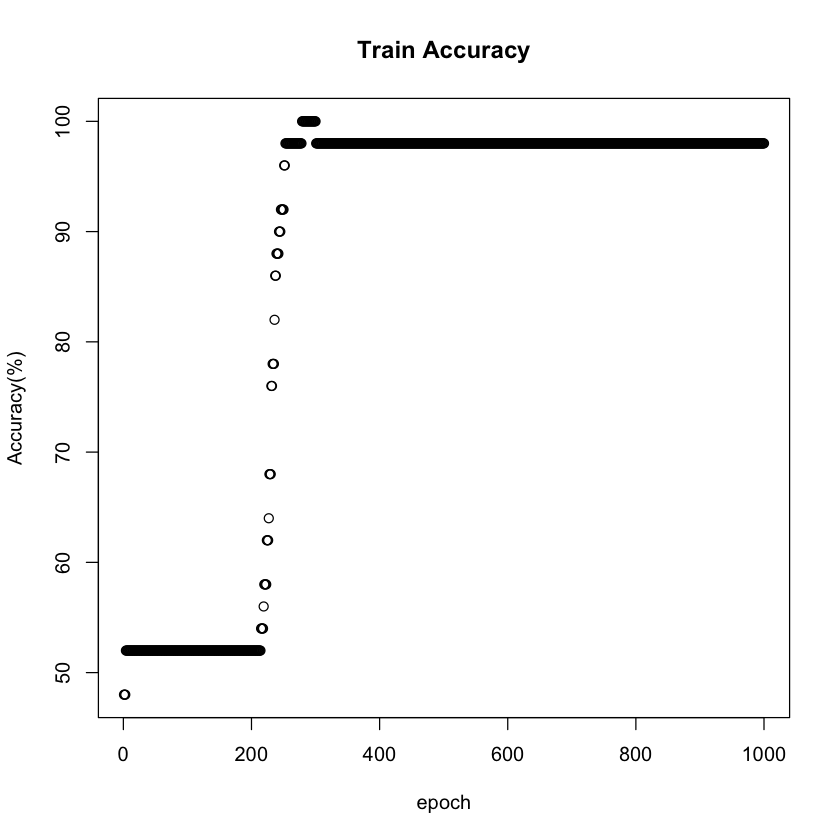

In [8]:
## Train Accuracy
plot(train.accuracy, main='Train Accuracy', xlab ='epoch', ylab='Accuracy(%)')

# Linearly Non-separable Classes
## Synthetic Data Generation 
The dataset we generated for the previous experiemnts is rather easily separable using a linear model. One can modify the data generator code and repeat the experiments on more difficult samples (i.g., closer $\mu$, non-shared and identical $\Sigma$, or very imbalanced class sizes). Another approach to challenge our NN is to apply it on linearly non-separable classes where at least one of the classes is multi-modal (like two or more separate islands). The code below does the job. 

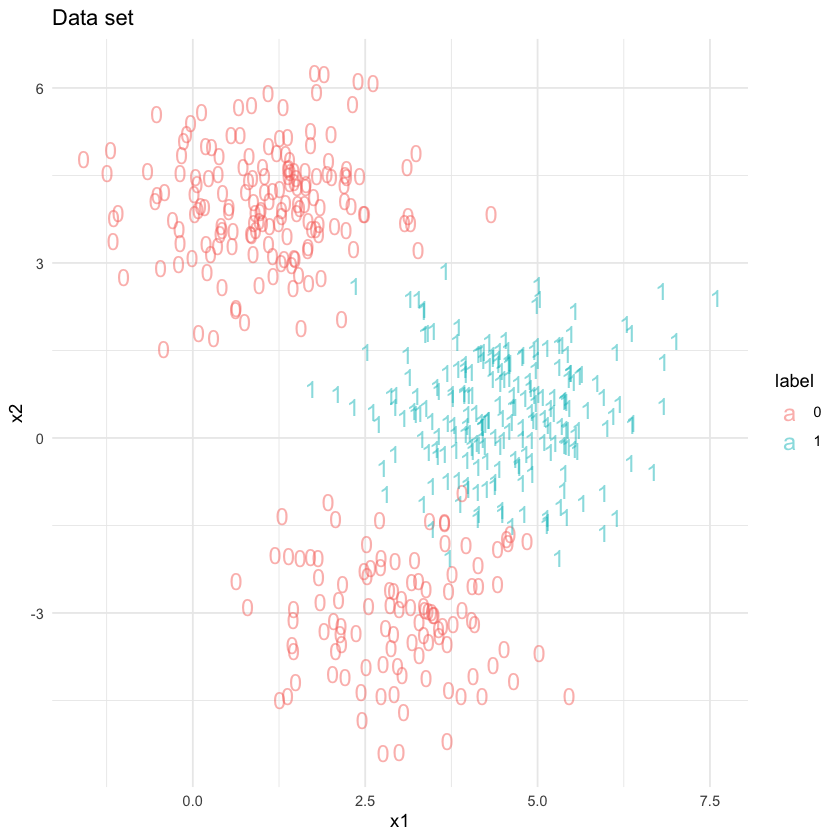

In [9]:
## Initialization
set.seed(12345)
N <- 500
c0 <- '0'; c1 <- '1'; c2 <- '2' # class labels
mu0 <- c(1.0, 4.0); p0 <- 0.30
mu1 <- c(4.5, 0.5); p1 <- 0.50
mu2 <- c(3.0, -3.0); p2 <- 1 - p0 - p1

sigma <- matrix(c(1, 0, 0, 1), nrow=2, ncol=2, byrow = TRUE) # shared covariance matrix
sigma0 <- sigma;   sigma1 <- sigma;    sigma2 <- sigma

data <- data.frame(x1=double(), x2=double(), label=double()) # empty data.frame

## Generate class labels
data[1:N,'label'] <- sample(c(c0,c1,c2), N, replace = TRUE, prob = c(p0, p1, p2))
## calculate the size of each class
N0 <- sum(data[1:N,'label']==c0);
N1 <- sum(data[1:N,'label']==c1); N2 <- N - N0 - N1

## Sample from the Gaussian distribution accroding to the class labels and statitics.
data[data[1:N,'label']==c0, c('x1', 'x2')] <- rmvnorm(n = N0, mu0, sigma0)
data[data[1:N,'label']==c1, c('x1', 'x2')] <- rmvnorm(n = N1, mu1, sigma1)
data[data[1:N,'label']==c2, c('x1', 'x2')] <- rmvnorm(n = N2, mu2, sigma2)
data[data[1:N,'label']==c2, 'label'] <- c0
## Take a look at the data set
ggplot(data=data, aes(x=x1, y=x2, color=label, label=ifelse(label==c0, '0', '1'))) +
    geom_text(size = 5, alpha=0.5) +
    ggtitle ('Data set') +
    theme_minimal()
N <- nrow(data)
train.len <- round(N/2)
train.index <- sample(N, train.len, replace = FALSE)
train.data <- data[train.index, c('x1', 'x2')]
test.data <- data[-train.index, c('x1', 'x2')]
train.label <- data[train.index, 'label']
test.label <- data[-train.index, 'label']
# Some conversions:
## rename just for convenience
N <- train.len 

## convert data and labels to matrices
X1 <- t(unname(data.matrix(train.data))) 
T1 <- t(data.matrix(as.numeric(train.label))) 

X2 <- t(unname(data.matrix(test.data))) 
T2 <- t(data.matrix(as.numeric(test.label))) 

Now, we can repeat the above experiments on this linearly non-separable dataset. However, let's first put the pieces of the above code togather to define a function which trains a 3-layer NN with `K` units in the hiden layer, and returns the training and testing accuracies.

In [10]:
NN <- function(K, N, X1, T1, X2, T2, tracing=FALSE, epoch.max=500){
    # Setting parameters
    D <- 2
    eta <- 0.1 # learning rate
    lambda <- 0.0001 # regularization term
    # initialization
    if (tracing==TRUE) {train.accuracy <- matrix(0,nrow=epoch.max, ncol=1); test.accuracy <- train.accuracy}
    epoch <- 1 # epoch (iteration) counter
    terminate <- FALSE   # termination criteria
    W1 <- matrix(0.01*rnorm(D*K, sd=0.5), nrow=K, ncol=D)
    b1 <- matrix(0*rnorm(1*K), nrow=K, ncol=1)
    W2 <- matrix(0.01*rnorm(K*1, sd=0.5), nrow=1, ncol=K)
    b2 <- matrix(0*rnorm(1*1), nrow=1, ncol=1)
    # main loop
    while (!terminate){   
        ## delta vectors/matrices initialization
        W1.d <- W1 *0
        b1.d <- b1 *0
        W2.d <- W2 *0
        b2.d <- b2 *0
        ## inner loop for each train sample
        for (i in 1:N){
            ## Feedforward:
            list[a1, a2, a3, y, z2, z3] <- feedforward(X1[,i], T1[i], W1, b1, W2, b2)          
            ## Backpropagation:
            list[d2, d3] <- backpropagation(T1[i], W2, z2, z3, a3)
            ## calculate the delta values
            ### 1st layer
            W1.d <- W1.d + d2 %*% t(a1)
            b1.d <- b1.d + d2
            ### 2nd layer
            W2.d <- W2.d + d3 %*% t(a2)
            b2.d <- b2.d + d3
        }
        ## update weight vectors and matrices
        W1 <- W1 - eta * (W1.d/N + lambda*W1)
        b1 <- b1 - eta * (b1.d/N)
        W2 <- W2 - eta * (W2.d/N + lambda*W2)
        b2 <- b2 - eta * (b2.d/N)
        ## record the errors
        if (tracing==TRUE){
            train.accuracy[epoch]<- accuracy(prediction(X1, W1, W2, b1, b2), T1)
            test.accuracy[epoch]<- accuracy(prediction(X2, W1, W2, b1, b2), T2)
        }
        ## increase the iteration counter
        epoch <- epoch + 1
        ## check the termination criteria
        if (epoch > epoch.max) {terminate <- TRUE}
    }
    if (tracing==FALSE){
        train.accuracy <- accuracy(prediction(X1, W1, W2, b1, b2), T1)
        test.accuracy <- accuracy(prediction(X2, W1, W2, b1, b2), T2)
    }
    return(cbind(train.accuracy,test.accuracy))
}

Now we train our network and plot the training accuracy.

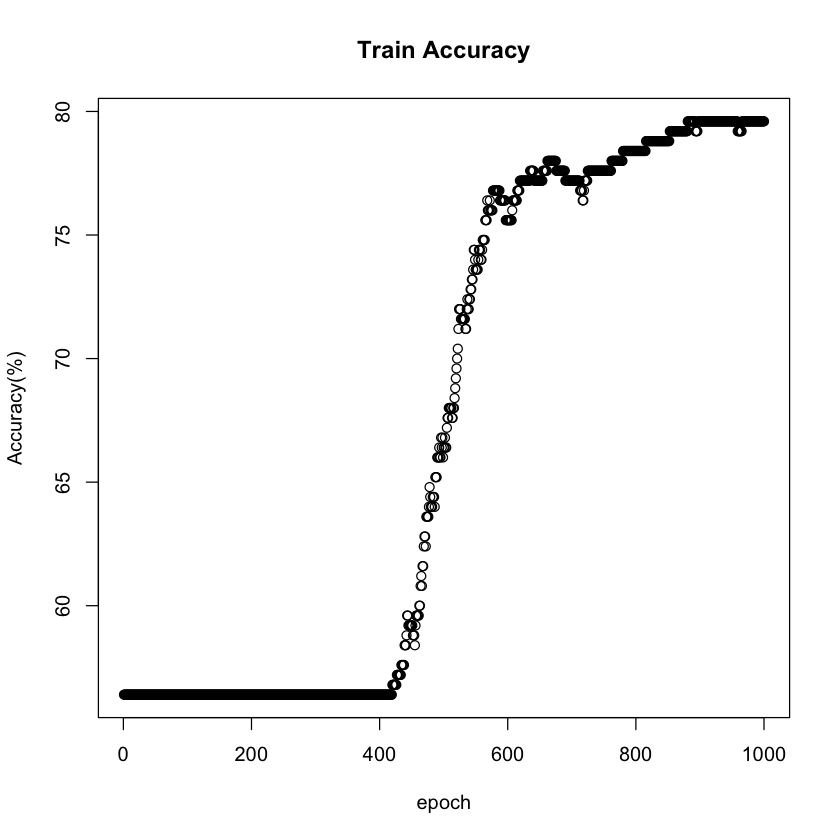

In [11]:
resutls <- NN(3, N, X1, T1, X2, T2, tracing = TRUE, epoch.max = 1000)
plot(resutls[,1], main='Train Accuracy', xlab ='epoch', ylab='Accuracy(%)')

## Model Selection
In Module 2 and 3 we leanred that models may have diifferent levels of generalization according to their complexities. We also know that the number of units in the hidden layer has a direct effect on the model complexity. Therefore, we intend to study the effect of the  hidden layer size on the out neural network performance. To perform such study, we repeat the above experiment several times (every time with a different subset of training samples) for different values of $K$. Then, we draw a boxplot to show the results.

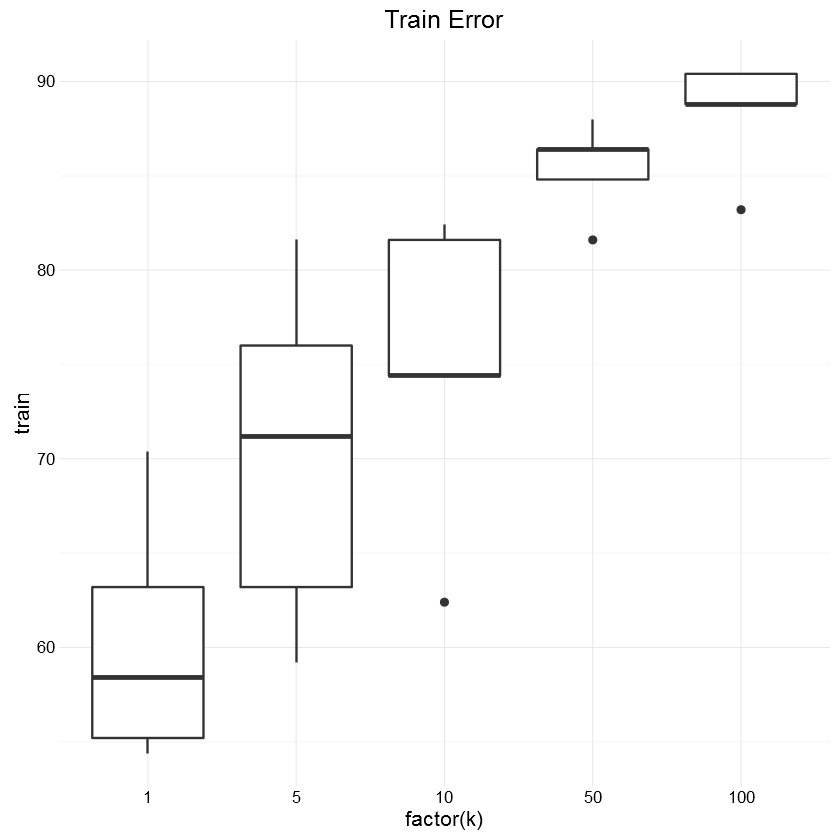

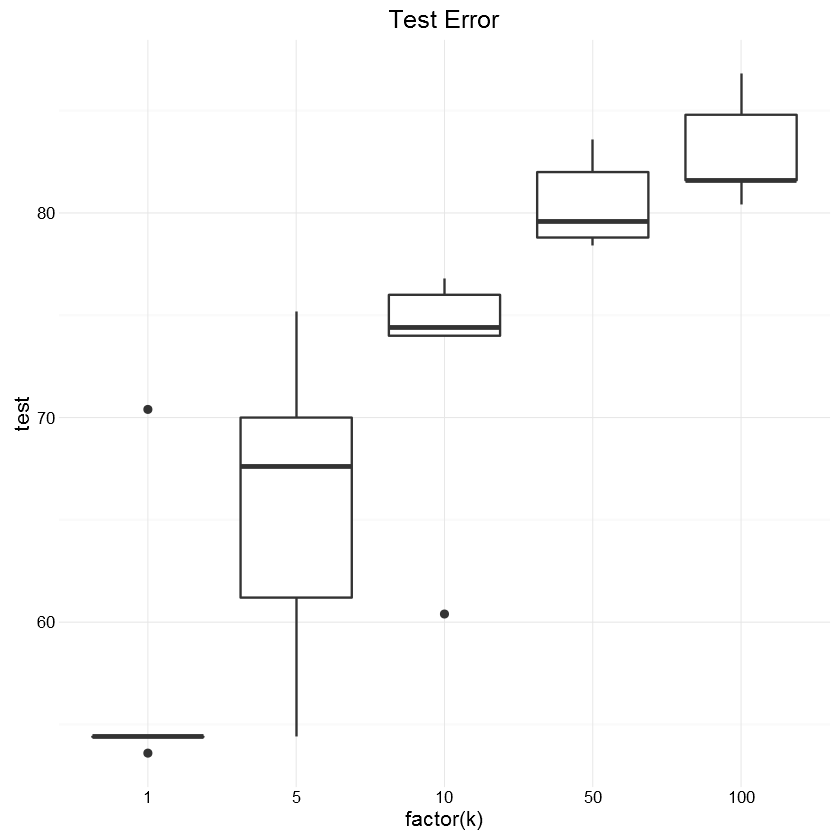

In [19]:
K <- c(1, 5, 10, 50, 100)  
T <- 1:5
results <- data.frame(k=rep(K, times = length(T), each = 1), t=rep(T, times = 1, each = length(K)),
                     train=rep(0, length(K) * length(T)), test=rep(0, length(K) * length(T)))
for (k in K){
    for (t in T){
        indx <- sample(1:N, round(N/2), replace = TRUE)
        results[results$k==k & results$t==t, c('train', 'test')] <- NN(k, round(N/2), X1[,indx], T1[indx], X2, T2)
    }
}

ggplot(data=results, aes(factor(k), train)) + geom_boxplot() + ggtitle('Train Error') + theme_minimal()
ggplot(data=results, aes(factor(k), test)) + geom_boxplot()  + ggtitle('Test Error') + theme_minimal()

## Discussions
